# Word Embeddings

We are going to play a bit with GloVe to get a feeling what is it.

Documentation: https://nlp.stanford.edu/projects/glove/ .

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import networkx as nx
import matplotlib.pyplot as plt

stopwords_list = set(stopwords.words('english'))
stoppunctuation_list = set(string.punctuation)

pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreikristov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# function definitions

def word_embeddings(file):
    """
    Download word vectors from a file.

    Parameters
    ----------
    file : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    with open(file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

def cosine_similarity(v1, v2):
    """
    Calculate cosine similarity between two vectors.

    Parameters
    ----------
    v1 : _type_
        _description_
    v2 : _type_
        _description_
    """
    v1_len = np.sqrt(np.sum(v1 * v1))
    v2_len = np.sqrt(np.sum(v2 * v2))

    return np.dot(v1, v2) / (v1_len * v2_len)

def get_top_N_similar_words(target_word, word_to_vec_map, top_N=10):
    """
    _summary_

    Parameters
    ----------
    word : _type_
        _description_
    word_to_vec_map : _type_
        _description_
    """

    # lowercase the word
    target_word = target_word.lower()

    #  get the embedding vector for a word
    word_e = word_to_vec_map[target_word.lower()]

    # get all words in the word embeddings vector
    all_words = word_to_vec_map.keys()

    result_dict = {}
    for w in all_words:
        if w != target_word and w not in stopwords_list and w not in stoppunctuation_list:
            cosine_sim = cosine_similarity(word_e, word_to_vec_map[w])
            result_dict[w] = cosine_sim

    result_df = pd.DataFrame(list(result_dict.items()), columns=['word', 'cosine_similarity'])
    result_df['target_word'] = target_word
    result_df = result_df[['target_word','word', 'cosine_similarity']]
    result_df.sort_values(by='cosine_similarity', ascending=False, inplace=True)
    
    return result_df.head(top_N)


def find_analogy(word_a, word_a_pair, word_b, word_to_vec_map):
    """
    Performs the word analogy search so that: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_a_pair -- a word, string
    word_b -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Retur
    word_b_pair --  the word such that word_a_pair - word_a is close to word_b_pair - word_b, as measured by cosine similarity
    """
    
    # convert words to lowercase
    word_a, word_a_pair, word_b = word_a.lower(), word_a_pair.lower(), word_b.lower()
    
    # Get the word embeddings 
    e_a, e_a_pair, e_b = word_to_vec_map[word_a], word_to_vec_map[word_a_pair], word_to_vec_map[word_b]

    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # to avoid best_word being one of the input words, skip the input words
    # place the input words in a set for faster searching than a list
    # We will re-use this set of input words inside the for-loop
    word_exceptions = set([word_a, word_a_pair, word_b])
    
    # loop over the whole word vector set
    result_dict = {}
    for w in words:        
        # to avoid best_word being one of the input words, skip the input words
        if w in word_exceptions:
            continue
        
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity(e_a_pair - e_a, word_to_vec_map[w] - e_b)
        
        result_dict[w] = cosine_sim
        #print(w, cosine_sim, result_dict[w])

        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
    
    result_df = pd.DataFrame(list(result_dict.items()), columns=['word_b_pair', 'cosine_similarity'])
    
    return best_word, result_df.sort_values(by='cosine_similarity', ascending=False)


def build_graph_for_target_word(target_word, n_top_similar_to_vis=3):
    """
    Build a graph for target_word similar words and their similarities.

    Parameters
    ----------
    target_word : string
        A word to extract similarities for.
    n_top_similar_to_vis : int, optional
        Number of similar to the target_word words to show on the graph
    """
    # get similarities for the target word
    result_df = get_top_N_similar_words(target_word=target_word, word_to_vec_map=word_to_vec_map, top_N=20)

    # take similarities for the top n similar to target words
    top_words = result_df['word'].values[:n_top_similar_to_vis]
    # extract their similarities and add to result_df
    for w in top_words:
        result_df_ = get_top_N_similar_words(target_word=w, word_to_vec_map=word_to_vec_map, top_N=10)
        result_df = pd.concat([result_df, result_df_], axis=0)
    
    # build a graph
    G = nx.Graph()
    # add main nodes
    for tw in result_df['target_word'].unique():
        G.add_node(target_word.lower())
    # add all other nodes and edges
    for target_word, word, similarity in zip(result_df['target_word'], result_df['word'], result_df['cosine_similarity']):
        if word not in G.nodes():
            G.add_node(word.lower())
        G.add_edge(target_word, word, weight=similarity)

    # Extract positions of nodes in the graph using spring layout (distance proportional to similarity)
    node_pos = nx.spring_layout(G, weight='weight')
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # draw the graph
    plt.figure(figsize=(10,7))
    nx.draw(G, pos=node_pos, with_labels=True, node_size=1000, font_size=6, font_color='black', node_color='lightblue')
    nx.draw_networkx_edges(G=G, pos=node_pos, width=[w*1 for w in edge_weights.values()])
    plt.show()


### Download word embeddings (GloVe)

In [5]:
# read embeddings
file = '../readonly/glove.6B.50d.txt' # file with embeddings
words, word_to_vec_map = word_embeddings(file = file)

### Get top N words similar to a word

In [18]:
target_word = 'Italy'

get_top_N_similar_words(target_word=target_word, word_to_vec_map=word_to_vec_map, top_N=20)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreikristov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target_word,word,cosine_similarity
900,italy,spain,0.861642
902,italy,italian,0.842328
2867,italy,portugal,0.814457
271,italy,france,0.778864
1208,italy,brazil,0.760169
2636,italy,milan,0.755182
2478,italy,rome,0.750859
1901,italy,argentina,0.750747
2171,italy,switzerland,0.740357
390,italy,germany,0.738681


### Show similar words as a graph

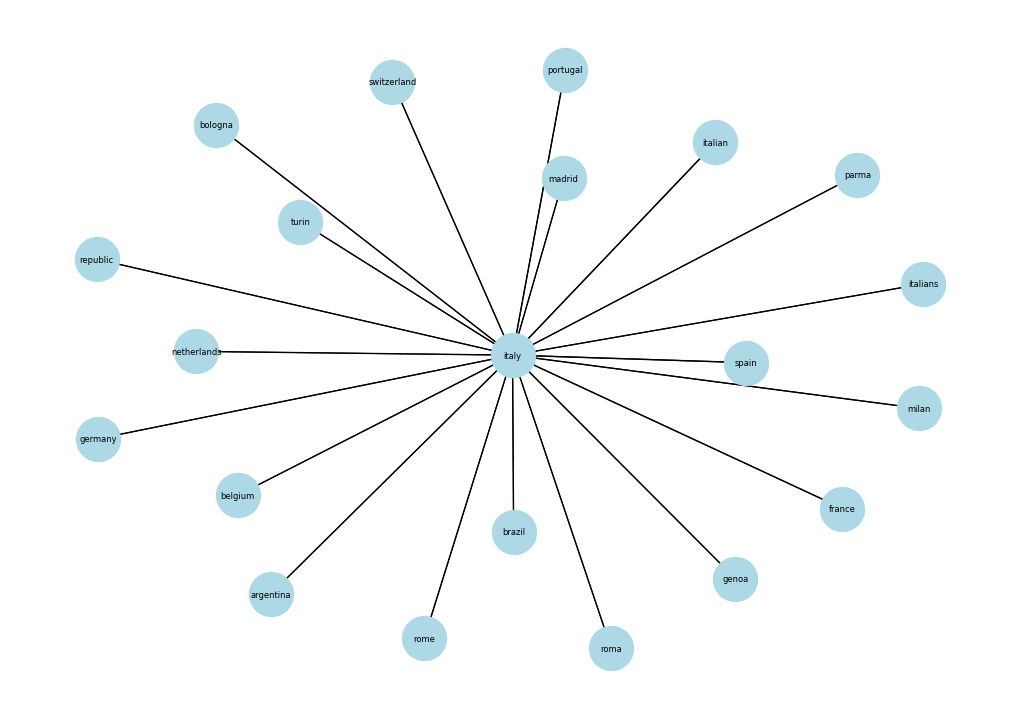

In [38]:
build_graph_for_target_word(target_word='Italy', n_top_similar_to_vis=0)

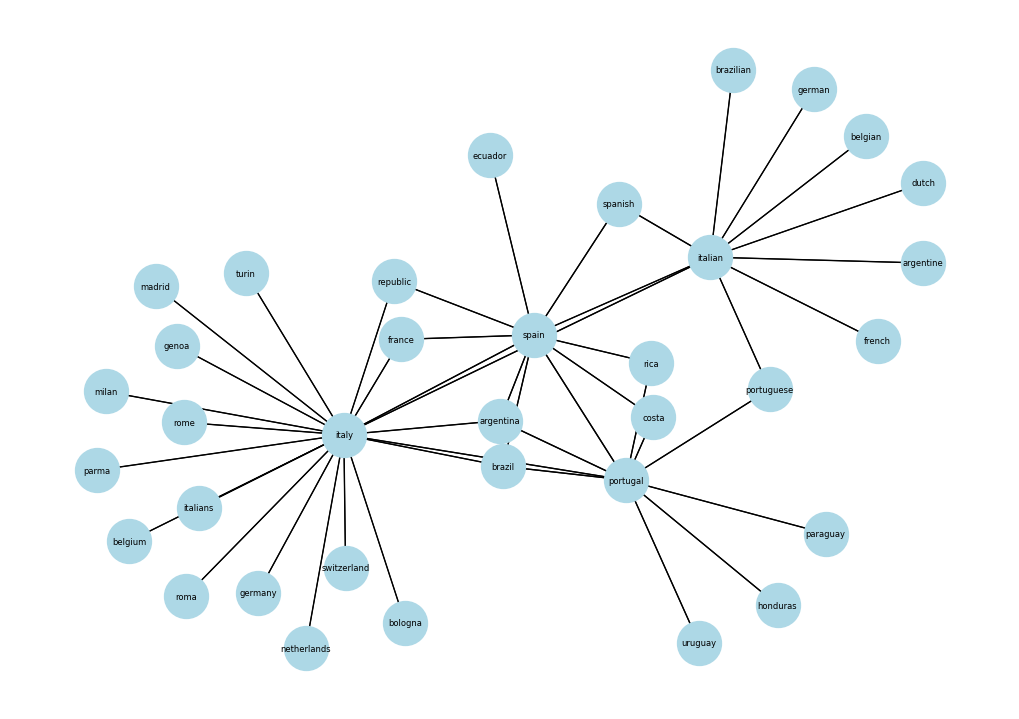

In [39]:
# show graph with top-3 neighbors
build_graph_for_target_word(target_word='Italy', n_top_similar_to_vis=3)

### Check similarity of Country Names

    w1       w2  cosine_similarity
0  usa   israel           0.229507
1  usa    italy           0.307111
2  usa   france           0.395918
3  usa  germany           0.440348
4  usa   russia           0.314743


<Axes: xlabel='w2', ylabel='w1'>

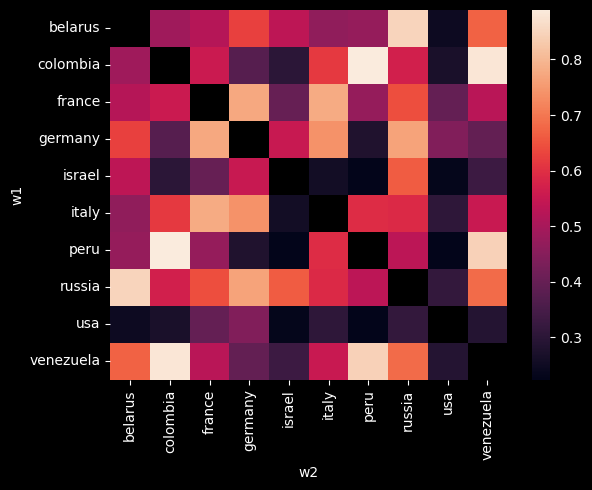

In [4]:
# check embeddings on countries: which are closer related?

import itertools

word_list = ['usa', 'israel', 'italy', 'france', 'germany', 'russia', 'belarus','peru', 'venezuela', 'colombia']
# make permutations of 2 words from the list
permutations = list(itertools.permutations(word_list, 2))
permutations_df = pd.DataFrame(permutations, columns=['w1', 'w2'])

cosine_similarity_arr = []
for idx, row in permutations_df.iterrows():
    #print(row['w1'], row['w2'])
    w1_embd = word_to_vec_map[row['w1']]
    w2_embd = word_to_vec_map[row['w2']]
    #print(w1_embd)
    cosine_similarity_arr.append(cosine_similarity(w1_embd, w2_embd))
    #print(cosine_similarity(w1_embd, w2_embd))

permutations_df['cosine_similarity'] = cosine_similarity_arr

print(permutations_df.head())

result_df_pivot = pd.pivot_table(data=permutations_df, values='cosine_similarity', index='w1', columns='w2')

sns.heatmap(data=result_df_pivot, vmin=(result_df_pivot.min()).min(), vmax=(result_df_pivot.max()).max())


### Find analogy

Analogy we're going to solve: 
```
if a - b, then c - ?
```

#### Analogy Example 1

In [41]:
# find analogy: usa - hotdog, italy - <expected "pasta"> (try alos vice versq)
word_a = 'usa'
word_a_pair='hotdog' # 'dollar', 
word_b='italy'
word, result_df = find_analogy(word_a=word_a, word_a_pair=word_a_pair, word_b=word_b, word_to_vec_map=word_to_vec_map)
print(word)
result_df.head(20)

pappardelle


,word_b_pair,cosine_similarity
205029,pappardelle,0.676916
337382,strazzer,0.664905
237953,wacked,0.664840
295525,santopadre,0.663609
236529,strangulated,0.663174
152755,tidily,0.663171
169781,rajaonarivelo,0.662302
160567,irredentism,0.661643
351671,familiarising,0.659290
347470,dutti,0.656016


#### Analogy Example 2

In [24]:
# find analogy: italy - italian, spain - <expected "spanish">
word_a = 'italy'
word_a_pair='italian' 
word_b='spain'
word, result_df = find_analogy(word_a=word_a, word_a_pair=word_a_pair, word_b=word_b, word_to_vec_map=word_to_vec_map)
print(word)
result_df.head(5)

spanish


,word_b_pair,cosine_similarity
1138,spanish,0.887530
4553,argentine,0.674749
3575,portuguese,0.644860
348,french,0.634735
8337,peruvian,0.606074


#### Analogy Example 3

In [25]:
# find analogy: italy - rome, india - <expected "delhi">
word_a = 'italy'
word_a_pair='rome' 
word_b='india'
word, result_df = find_analogy(word_a=word_a, word_a_pair=word_a_pair, word_b=word_b, word_to_vec_map=word_to_vec_map)
print(word)
result_df.head(5)

al-azhar


,word_b_pair,cosine_similarity
85617,al-azhar,0.683860
2608,temple,0.656698
3935,delhi,0.636397
40598,jinnah,0.636264
6814,prayers,0.628291


#### Analogy Example 4

In [26]:
# find analogy: man - woman, boy - <expected "girl">
word_a = 'man'
word_a_pair='woman' 
word_b='boy'
word, result_df = find_analogy(word_a=word_a, word_a_pair=word_a_pair, word_b=word_b, word_to_vec_map=word_to_vec_map)
print(word)
result_df.head(5)

girl


,word_b_pair,cosine_similarity
1746,girl,0.669509
5505,pregnant,0.458006
18010,816-822-8448,0.445294
102047,lactating,0.424976
49226,unwed,0.420873


## Gender bias in GloVe word embeddings

In [34]:
# this vector represents gender
gender_vector = word_to_vec_map['woman'] - word_to_vec_map['man']
gender_vector

array([-0.087144  ,  0.2182    , -0.40986   , -0.03922   , -0.1032    ,
        0.94165   , -0.06042   ,  0.32988   ,  0.46144   , -0.35962   ,
        0.31102   , -0.86824   ,  0.96006   ,  0.01073   ,  0.24337   ,
        0.08193   , -1.02722   , -0.21122   ,  0.695044  , -0.00222   ,
        0.29106   ,  0.5053    , -0.099454  ,  0.40445   ,  0.30181   ,
        0.1355    , -0.0606    , -0.07131   , -0.19245   , -0.06115   ,
       -0.3204    ,  0.07165   , -0.13337   , -0.25068714, -0.14293   ,
       -0.224957  , -0.149     ,  0.048882  ,  0.12191   , -0.27362   ,
       -0.165476  , -0.20426   ,  0.54376   , -0.271425  , -0.10245   ,
       -0.32108   ,  0.2516    , -0.33455   , -0.04371   ,  0.01258   ])

In [35]:
# how man's woman's names relate with gender_vector
name_list = ['andrei','isabel', 'john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for name in name_list:
    print(name, cosine_similarity(gender_vector, word_to_vec_map[name]))

andrei -0.10398300432276185
isabel 0.2895489176189947
john -0.23163356145973724
marie 0.31559793539607295
sophie 0.31868789859418784
ronaldo -0.3124479685032943
priya 0.17632041839009396
rahul -0.16915471039231714
danielle 0.24393299216283892
reza -0.0793042967219955
katy 0.2831068659572615
yasmin 0.2331385776792875


In [14]:
v1 = np.array([1,2,3])
v2 = np.array([4,5,6])

print(np.dot(v1,v2))
print(v1*v1)
print(1*4 + 2*5 + 3*6)
print(cosine_similarity(v1,v2))

32
[1 4 9]
32
0.9746318461970762
